# Analysis of minimal TF's needed for reprogramming

## Load data
Notes:

1. Only singlets are included
2. RIDD infected

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pathlib import Path
import re
import seaborn as sns
import rushd as rd
from statannotations.Annotator import Annotator

no_yellow_viridis = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap('viridis', 256)(np.linspace(0,0.85,256)))

# Required descriptors for annotate
from scipy.stats import ttest_ind
from statannotations.stats.StatTest import StatTest
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

In [3]:
# Where to save figures
figpath = '../figures/fig3/'

# List of data folder names
dir_list = ['2022.06.13_Hb9_minNIL_14dpi_1',
            '2022.06.13_Hb9_minNIL_14dpi_2',
            '2022.06.15_Hb9_minNIL_14dpi_3',
            '2022.06.15_Hb9_minNIL_14dpi_4']

# Store all data in list of dfs which will be converted to df at end
data = list()

# get all csvs for each dir
for (j, dir_name) in enumerate(dir_list):

    path = rd.datadir / '2022.06.13_Hb9_minNIL_14dpi_1-4' / dir_name / 'export_singlets'
    files = Path(path).glob('*.csv') 

    for i, file in enumerate(files):
        
        # Extract metadata from csv title
        match = re.search(
            'export_(?P<cond>.+).(?P<sampleNum>\d)_Singlets.csv', file.name)
        # If csv is a ctrl file it won't match so ignore
        if match is None:
            continue

        cond = match.group('cond')
        sampleNum = match.group('sampleNum')

        # Rename HIP conditions
        HIPW_cat = False
        if cond[-4:] == 'HIPW':
           HIPW_cat = True
           cond = cond[:-5] # cut out .HIPW
        
        # Load as df and note header is on 0th row
        df = pd.read_csv(file, header=0)

        # Update columns in df with metadata from file name
        df['cond'] = cond
        if HIPW_cat:
            df['cond.DDRR'] = cond + ".DDRR"
        else:
            df['cond.DDRR'] = cond 
        df['replicate'] = j
        df['sampleNum'] = sampleNum
        df['HIPW_cat'] = HIPW_cat

        data.append(df)

# Convert list of dfs into single df
data = pd.concat(data, ignore_index=True)

# Eliminate any negative fluor
data = data.loc[
    (data['eGFP-A'] > 0) &
    (data['FSC-A'] > 0) &
    (data['SSC-A'] > 0)]

# Look at eGFP for NILDDRR to determine eGFP gate

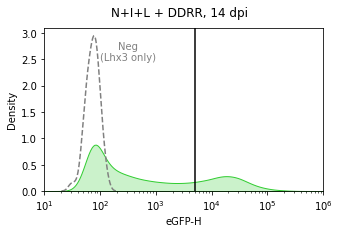

In [4]:
# Threshold for iMNs
eGFP_H_thresh = 5*10**3

# Downsample to 100,000 cells from NIL + HIP
# small_data = data.groupby(['cond']).sample(n=10**4, random_state=1)
small_data = data[(data['cond'] == 'N+I+L') & (
    data['HIPW_cat'] == True)].sample(n=10**5, random_state=1)


fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot eGFP-H
x = 'eGFP-H'
sns.kdeplot(ax=ax, data=small_data, x=x,
            log_scale=(True, False), fill=True, color='limegreen',
            common_norm=True)
ax.axvline(eGFP_H_thresh, 0, 1, color='black')

# Plot neg ctrl
sns.kdeplot(data=data[(data['cond'] == 'L') & (
    data['HIPW_cat'] == False)].sample(n=100, random_state=1), x=x, common_norm=True,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg\n(Lhx3 only)', (0.3, 0.8), color='grey', xycoords='axes fraction', ha='center')


# Title
plt.suptitle('N+I+L + DDRR, 14 dpi')
# Adjust limits
eGFP_lim = (10, 10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

# plt.savefig(figpath + 'SI/eGFP-H_dist.svg', bbox_inches='tight')

Looks like eGFP = 5x10^3 is good

## Look at results for eGFP-H

### Categorize cells based on eGFP-H

In [5]:
# Categorize iMNs based on eGFP_thresh
data['eGFP_cat'] = 'fib'
data.loc[(data['eGFP-H'] > eGFP_H_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of eGFP-A+
well_group = ['cond', 'HIPW_cat', 'replicate']
count_df_reps = data.groupby([*well_group, 'sampleNum', 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'sampleNum']).transform('sum')).dropna().reset_index(name='percent')

# Extract just the iMNs
data_iMN_percent_reps = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'iMN')]

# Get iMN yield per condition
seedNum = 10**4 # Seeded 10k MEFs/96-wel
# Divide by seeded cells to get yield, then extract just the iMNs
data_iMN_yield_reps = (count_df_reps*100/seedNum).reset_index(name='yield')
data_iMN_yield_reps = data_iMN_yield_reps.loc[data_iMN_yield_reps['eGFP_cat'] == 'iMN']

# Reduce to bio reps
data_iMN_percent = data_iMN_percent_reps.groupby(well_group)['percent'].mean().reset_index()
data_iMN_yield = data_iMN_yield_reps.groupby(well_group)['yield'].mean().reset_index()

# Just look at 6F and N+I+L

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL_False vs. NIL_True: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:8.464e-04 Stat=-6.638e+00
6F_False vs. 6F_True: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.141e-03 Stat=-5.564e+00
6F_True vs. NIL_True: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:9.682e-04 Stat=-6.473e+00
p-value annotation 

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


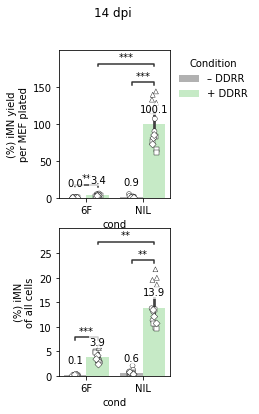

In [7]:
# General plotting params
x = 'cond'
hue = 'HIPW_cat'
hue_order = [False, True]
units = 'sampleNum'
colormap = {hue_order[0]: 'black', hue_order[1]: 'limegreen'}
cond_list = ['6F', 'NIL']
marker_list = ['o', 's', '^', 'D']

# Pairs for stats comp
pairs = [(('6F', False), ('6F', True)),
         (('NIL', False), ('NIL', True)),
         (('6F', True), ('NIL', True))]

fig, ax = plt.subplots(2, 1, figsize=(2, 6))

# Plot iMN yield per MEF plated
y = 'yield'
sns.barplot(ax=ax[0], data=data_iMN_yield_reps,
            x=x, y=y, hue=hue, hue_order=hue_order, order=cond_list,
            units=units,
            palette=colormap, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(
        ax=ax[0], data=data_iMN_yield_reps[data_iMN_yield_reps.replicate == rep],
        x=x, y=y, hue=hue, hue_order=hue_order, order=cond_list,
        dodge=True, marker=marker_list[i],
        palette={True: 'white', False: 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)

# Add in stats for iMN yield
annot = Annotator(ax=ax[0], data=data_iMN_yield, x=x, y=y, pairs=pairs, order=cond_list, hue=hue, hue_order=hue_order)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Plot iMN percent of all cells
y = 'percent'
sns.barplot(ax=ax[1], data=data_iMN_percent_reps,
            x=x, y=y, hue=hue, hue_order=hue_order, order=cond_list,
            units=units,
            palette=colormap, alpha=0.3)
for (i, rep) in enumerate(data_iMN_percent_reps.replicate.unique()):
    sns.stripplot(
        ax=ax[1], data=data_iMN_percent_reps[data_iMN_percent_reps.replicate == rep],
        x=x, y=y, hue=hue, hue_order=hue_order, order=cond_list,
        dodge=True, marker=marker_list[i],
        palette={True: 'white', False: 'white'}, size=5,
        edgecolor='black', linewidth=0.4,)
                
# Add in stats for iMN percent
annot = Annotator(ax=ax[1], data=data_iMN_percent, x=x, y=y, pairs=pairs, order=cond_list, hue=hue, hue_order=hue_order)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Format
fig.suptitle('14 dpi')
ax[0].yaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax[0].set_yticks(np.arange(0, 200, 50))
ax[1].get_legend().remove()
ax[1].yaxis.set_label_text('(%) iMN\nof all cells')
ax[1].set_yticks(np.arange(0, 30, 5))

# Adjust labels
lmap = {'True':'+ DDRR', 'False':'\u2013 DDRR'}
h,l = ax[0].get_legend_handles_labels()
sns.move_legend(ax[0], handles=h[-len(hue_order):],labels=[lmap[i] for i in l[-len(hue_order):]],
    title='Condition', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.1f', padding=10)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))

# plt.savefig(figpath + 'iMN_yield_minNIL_6F_v_NIL_small.svg', bbox_inches='tight')

## How does it look with and without DDRR

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

N+I vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.622e-02 Stat=-3.642e+00
N+L vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.670e-02 Stat=-3.617e+00
I+L vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.627e-02 Stat=-3.639e+00


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

N+I vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.443e-05 Stat=-1.247e+01
N+L vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.532e-05 Stat=-1.239e+01
I+L vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.454e-05 Stat=-1.246e+01


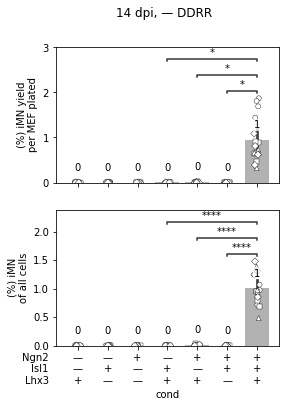

In [9]:
# General plotting params
x = 'cond'
color = 'black'
cond_list = ['L',  'I', 'N', 'I+L', 'N+L', 'N+I', 'N+I+L']
units = 'sampleNum'
marker_list = ['o', 's', '^', 'D']
HIPW_cat = False

df_labels = pd.DataFrame(
    {
        "cond": ['L', 'I', 'N', 'I+L', 'N+L', 'N+I', 'N+I+L'],
        "Ngn2": ["—", "—", "+",   "—",   "+",   "+",     "+"],
        "Isl1": ["—", "+", "—",   "+",   "—",   "+",     "+"],
        "Lhx3": ["+", "—", "—",   "+",   "+",   "—",     "+"],
    }
)

# Pairs for stats comp
pairs = [('N+I+L', 'N+I'),
         ('N+I+L', 'N+L'),
         ('N+I+L', 'I+L')]

fig, ax = plt.subplots(2, 1, figsize=(4, 5.5))

# Plot iMN yield per MEF plated
y = 'yield'
sns.barplot(ax=ax[0], data=data_iMN_yield_reps[data_iMN_yield_reps.HIPW_cat == HIPW_cat],
    x=x, y=y, order=cond_list, units=units,
    color=color, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(ax=ax[0], data=data_iMN_yield_reps[(data_iMN_yield_reps.HIPW_cat == HIPW_cat) & (data_iMN_yield_reps.replicate == rep)],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5, 
        linewidth=0.4, edgecolor='black')
annot = Annotator(
    ax=ax[0], data=data_iMN_yield[data_iMN_yield.HIPW_cat == HIPW_cat],
    x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Plot iMN percent of all cells
y = 'percent'
sns.barplot(ax=ax[1], data=data_iMN_percent_reps[data_iMN_percent_reps.HIPW_cat == HIPW_cat],
    x=x, y=y, order=cond_list, units=units,
    color=color, alpha=0.3)
for (i, rep) in enumerate(data_iMN_percent_reps.replicate.unique()):
    sns.stripplot(
        ax=ax[1], data=data_iMN_percent_reps[(data_iMN_percent_reps.HIPW_cat == HIPW_cat) & (data_iMN_percent_reps.replicate == rep)],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4,)

# Add in stats for iMN yield
annot = Annotator(
    ax=ax[1], data=data_iMN_percent[data_iMN_percent.HIPW_cat == HIPW_cat],
    x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Format
fig.suptitle('14 dpi, — DDRR')
ax[0].yaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax[1].yaxis.set_label_text('(%) iMN\nof all cells')
ax[0].xaxis.set_label_text("")
ax[0].set_xticklabels("")
rd.plot.generate_xticklabels(df_labels=df_labels, ax_col=x,
    label_cols=["Ngn2", "Isl1", "Lhx3"], ax=ax[1])  

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=10)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# plt.savefig(figpath + 'SI/iMN_yield-percent_noDDRR.svg', bbox_inches='tight')

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

N+I vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.622e-02 Stat=-3.642e+00
N+L vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.670e-02 Stat=-3.617e+00
I+L vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.627e-02 Stat=-3.639e+00


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

N+I vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:4.547e-04 Stat=-7.442e+00
N+L vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.157e-04 Stat=-8.514e+00
I+L vs. N+I+L: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.371e-04 Stat=-9.228e+00


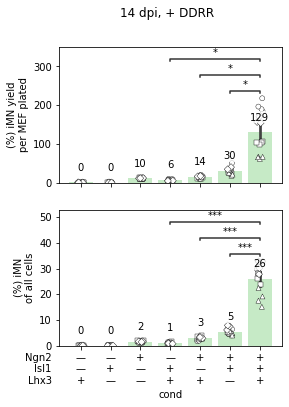

In [ ]:
# General plotting params
x = 'cond'
color = 'limegreen'
cond_list = ['L',  'I', 'N', 'I+L', 'N+L', 'N+I', 'N+I+L']
units = 'sampleNum'
marker_list = ['o', 's', '^', 'D']
HIPW_cat = True

df_labels = pd.DataFrame(
    {
        "cond": ['L', 'I', 'N', 'I+L', 'N+L', 'N+I', 'N+I+L'],
        "Ngn2": ["—", "—", "+",   "—",   "+",   "+",     "+"],
        "Isl1": ["—", "+", "—",   "+",   "—",   "+",     "+"],
        "Lhx3": ["+", "—", "—",   "+",   "+",   "—",     "+"],
    }
)

# Pairs for stats comp
pairs = [('N+I+L', 'N+I'),
         ('N+I+L', 'N+L'),
         ('N+I+L', 'I+L')]

fig, ax = plt.subplots(2, 1, figsize=(4, 5.5))

# Plot iMN yield per MEF plated
y = 'yield'
sns.barplot(ax=ax[0], data=data_iMN_yield_reps[data_iMN_yield_reps.HIPW_cat == HIPW_cat],
    x=x, y=y, order=cond_list, units=units,
    color=color, alpha=0.3)
for (i, rep) in enumerate(data_iMN_yield_reps.replicate.unique()):
    sns.stripplot(ax=ax[0], data=data_iMN_yield_reps[(data_iMN_yield_reps.HIPW_cat == HIPW_cat) & (data_iMN_yield_reps.replicate == rep)],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5, 
        linewidth=0.4, edgecolor='black')
annot = Annotator(
    ax=ax[0], data=data_iMN_yield[data_iMN_yield.HIPW_cat == False],
    x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Plot iMN percent of all cells
y = 'percent'
sns.barplot(ax=ax[1], data=data_iMN_percent_reps[data_iMN_percent_reps.HIPW_cat == HIPW_cat],
    x=x, y=y, order=cond_list, units=units,
    color=color, alpha=0.3)
for (i, rep) in enumerate(data_iMN_percent_reps.replicate.unique()):
    sns.stripplot(
        ax=ax[1], data=data_iMN_percent_reps[(data_iMN_percent_reps.HIPW_cat == HIPW_cat) & (data_iMN_percent_reps.replicate == rep)],
        x=x, y=y, order=cond_list,
        dodge=True, marker=marker_list[i],
        color='white', size=5,
        edgecolor='black', linewidth=0.4,)

# Add in stats for iMN yield
annot = Annotator(
    ax=ax[1], data=data_iMN_percent[data_iMN_percent.HIPW_cat == HIPW_cat],
    x=x, y=y, pairs=pairs, order=cond_list)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Format
fig.suptitle('14 dpi, + DDRR')
ax[0].yaxis.set_label_text('(%) iMN yield\nper MEF plated')
ax[1].yaxis.set_label_text('(%) iMN\nof all cells')
ax[0].xaxis.set_label_text("")
ax[0].set_xticklabels("")
rd.plot.generate_xticklabels(df_labels=df_labels, ax_col=x,
    label_cols=["Ngn2", "Isl1", "Lhx3"], ax=ax[1])  

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=10)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Misc plotting stuff
# plt.savefig(figpath + 'SI/iMN_yield-percent_DDRR.svg', bbox_inches='tight')